In [3]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

c:\Users\user\anaconda3\envs\aaa\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data = datasets.MNIST(root = 'data',train=True, download=True, transform=ToTensor(),target_transform=None)
test_data = datasets.MNIST(root='data',train=False,download=True,transform=ToTensor())

In [5]:
img,label=train_data[0]
class_names = train_data.classes

In [6]:
print(class_names)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


5


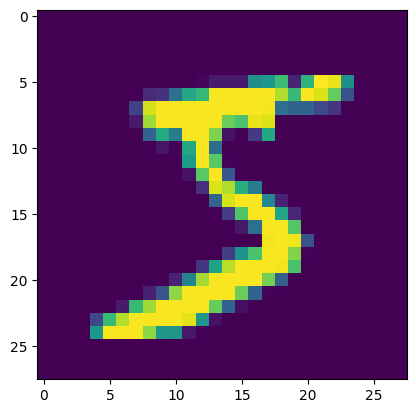

In [7]:
plt.imshow(img.squeeze())
print(label)

In [8]:
from torch.utils.data import DataLoader
BATCH_SIZE=32

train_dataloader = DataLoader(train_data,batch_size = BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=BATCH_SIZE, shuffle=False)

In [9]:
train_batch,train_label_batch = next(iter(train_dataloader))
train_batch.shape,train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [10]:
class cnn_classifier(nn.Module):
    def __init__(self,input_shape: int, hidden_units: int, output_shape:int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units, kernel_size=3,  stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units, kernel_size=3,  stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        return self.classifier(self.block_2(self.block_1(x)))

In [11]:
images = torch.randn(size=(32, 1, 64, 64))
test_image = images

In [12]:
model = cnn_classifier(input_shape = 1, hidden_units=10, output_shape=len(class_names))
img,label = train_data[0]
img.unsqueeze(dim=0).shape
model(img.unsqueeze(dim=0))

tensor([[ 0.0675,  0.0140, -0.0218, -0.0732, -0.0571, -0.0331, -0.0462,  0.0805,
          0.0299, -0.0456]], grad_fn=<AddmmBackward0>)

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr = 0.1)

In [14]:
#%%time
#from timeit import Timer as timer
from tqdm import tqdm


# model, device, epochs, loss_function, optimizer, train_dataloader, test_dataloader
def train(
    model: nn.Module, 
    train_dataloader: torch.utils.data.DataLoader, 
    test_dataloader: torch.utils.data.DataLoader, 
    device: torch.device, 
    epochs: int,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module):
    
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss, train_acc = 0.0,0.0
        for batch, (X,y) in enumerate(train_dataloader):
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)

            loss = loss_fn(y_pred,y)
            train_loss += loss.item()
            
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
            train_acc += (y_pred_class==y).sum().item()/len(y_pred)
        train_loss = train_loss / len(train_dataloader)
        train_acc = train_acc / len(train_dataloader)

        model.eval()
        test_loss, test_acc = 0.0,0.0
        with torch.inference_mode():
            for batch,(X,y) in enumerate(test_dataloader):
                X, y = X.to(device), y.to(device)
                test_pred_logit = model(X)
                loss = loss_fn(test_pred_logit, y)
                test_loss +=loss.item()
                test_pred_label = test_pred_logit.argmax(dim=1)
                test_acc += ((test_pred_label==y).sum().item()/len(test_pred_label))
        test_loss  = test_loss / len(test_dataloader)

        test_acc = test_acc / len(test_dataloader)
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )
        
    return train_loss, train_acc, test_loss, test_acc

In [15]:
%%time
train(model=model, train_dataloader=train_dataloader,test_dataloader=test_dataloader, device=device,epochs=5, optimizer=optimizer,loss_fn=loss_fn)

 20%|██        | 1/5 [00:15<01:02, 15.66s/it]

Epoch: 1 | train_loss: 0.4644 | train_acc: 0.8394 | test_loss: 0.0769 | test_acc: 0.9749


 40%|████      | 2/5 [00:31<00:47, 15.72s/it]

Epoch: 2 | train_loss: 0.0778 | train_acc: 0.9763 | test_loss: 0.0565 | test_acc: 0.9803


 60%|██████    | 3/5 [00:46<00:31, 15.59s/it]

Epoch: 3 | train_loss: 0.0600 | train_acc: 0.9811 | test_loss: 0.0523 | test_acc: 0.9836


 80%|████████  | 4/5 [01:02<00:15, 15.63s/it]

Epoch: 4 | train_loss: 0.0497 | train_acc: 0.9843 | test_loss: 0.0528 | test_acc: 0.9822


100%|██████████| 5/5 [01:17<00:00, 15.57s/it]

Epoch: 5 | train_loss: 0.0429 | train_acc: 0.9867 | test_loss: 0.0387 | test_acc: 0.9868
Wall time: 1min 17s


(0.042863824529204675,
 0.9867333333333334,
 0.038744582266437254,
 0.9868210862619808)

In [20]:
pwd

'c:\\Users\\user\\Desktop\\test'

In [22]:
torch.save(model.state_dict(),'c:\\Users\\user\\Desktop\\test')

PermissionError: [Errno 13] Permission denied: 'c:\\Users\\user\\Desktop\\test'